In [1]:
import gym
import gym.spaces
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import linalg
from copy import deepcopy
import time

hyper-parameters 

In [2]:
num_frames = 2
max_steps = 2000
num_games = 100

lr = 2e-5
training_epochs = 1
D_hid1 = 150
D_hid2 = 60
red_Din = 160
Din = 128
Dout = 6

one-hot vector is a vector in which only one component is 1, everything else is zero (0., 0., 1., 0.)

In [3]:
def int2onehot(n, max_n):
    res = np.zeros(max_n)
    res[n] = 1.
    return res

reduce the dimension of a vector by trasforming it to a basis defined by __V__ and then taking the first **keep&#95;dim** components

In [4]:
def dim_reduce(a, V, keep_dim):
    res = np.zeros([keep_dim])
    for i in range(keep_dim):
        res[i] = np.matmul(a, V[i])
    return res

Apply the poligy gradient

In [5]:
def red_train_agent2(training_epochs,red_games, commulative_rewards_np):
    merged_summary = tf.summary.merge_all()
    mx = commulative_rewards_np.max()
    mean = commulative_rewards_np.mean()
    amplitude = commulative_rewards_np.max() - commulative_rewards_np.min()
    step = 1
    for red_game, reward in zip(red_games, commulative_rewards_np):
        step += 1
        actions = np.array([_[1] for _ in red_game])
        observations = np.array([_[0] for _ in red_game])
        l = len(observations)
        for n in range(training_epochs):
            grads_buff = sess.run(red_grads, feed_dict={red_x:observations.reshape([l, red_Din]).astype(dtype=np.float32),
                                                   red_y_:actions.reshape([l, Dout]).astype(dtype=np.float32)})
            c = (reward - mean) / mean
            sess.run(red_apply_grads, \
                feed_dict={red_grad1_ph:(c * grads_buff[0][0]), \
                                red_grad2_ph:(c * grads_buff[1][0]), \
                               red_grad3_ph:(c * grads_buff[2][0]), \
                               red_grad4_ph:(c * grads_buff[3][0])})

play **num\_games** with **max\_steps** each by randomly sampling the action space

In [6]:
def play_random(num_games, max_steps, render):
    games = deque()
    env = gym.make("DemonAttack-ram-v4")
    commulative_rewards = deque()
    for i in range(num_games):
        #comp_observation = deque(maxlen = 3)
        observation = np.array(env.reset())
        comp_observation = deepcopy(observation) 
        comp_observations = deque()
        actions = deque()
        current_game = deque()
        commulative_reward = 0
        for j in range(max_steps):
            if render:
                env.render()            
            old_observation = observation
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            if len(comp_observation) == num_frames * 128:
                comp_observations.append(deepcopy(comp_observation))
            comp_observation = np.hstack((comp_observation, deepcopy(old_observation)))[-num_frames * 128:]
            commulative_reward += reward
            if(len(comp_observation) == num_frames * 128):
                current_game.append((comp_observation, int2onehot(action, env.action_space.n), reward))
                actions.append(int2onehot(action, env.action_space.n))
                comp_observations.append(comp_observation)
            if done:
                break;
        games.append(current_game)
        commulative_rewards.append(commulative_reward)
    #env.close()
    #del env
    return games, commulative_rewards

Play **num\_games** with **max\_steps** each by transforming the observations in the reduced dimension basis and using the neural network

In [7]:
def red_play(num_games, max_steps, render, V, sleep_s = 0.0):
    games = deque()
    actions = [ _ for _ in range(0, 6)]
    env = gym.make("DemonAttack-ram-v4")
    commulative_rewards = deque()
    for i in range(num_games):
        observation = env.reset()
        comp_observation = deepcopy(observation)
        current_game = deque()
        commulative_reward = 0
        for j in range(max_steps):
            if render:
                env.render()
                if sleep_s > 0.0:
                    time.sleep(sleep_s)
            if len(comp_observation) == num_frames * 128:
                #print "red_play: random_choice(probabilities)", len(comp_observation)
                red_observation = dim_reduce(comp_observation, V, red_Din)
                probabilities = sess.run(red_y, \
                                     feed_dict={red_x:red_observation.reshape([1, \
                                        len(red_observation)]).astype(dtype=np.float32)})
                action = np.random.choice(a=actions, p=probabilities[0])
                observation, reward, done, info = env.step(action)
                current_game.append((red_observation, int2onehot(action, env.action_space.n), reward))
            else:
                #print "red_play: action_space.sample:", len(comp_observation)
                action = env.action_space.sample()
                observation, reward, done, info = env.step(action)
            commulative_reward += reward
            
            comp_observation = np.hstack((comp_observation, observation))[-num_frames * 128:]
            if done:
                break;
        games.append(current_game)
        commulative_rewards.append(commulative_reward)
    #env.close()
    #del env
    return games, commulative_rewards

Generate some statistics for average reward per game of a random action agent

In [8]:
games, commulative_rewards = play_random(num_games=num_games, max_steps=2000, render=False)
commulative_rewards_np = np.array(commulative_rewards)

161.525


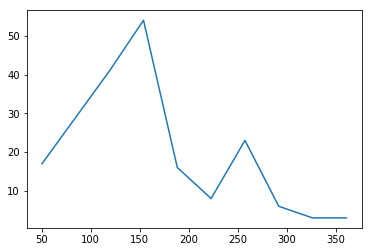

In [9]:
rewards_np = np.array( [_ for _ in commulative_rewards], dtype=np.float )
print (rewards_np.mean())
h = np.histogram(rewards_np)
plt.plot(h[1][:len(h[1]) - 1] + 10.5, h[0])
plt.show()

In [10]:
game = games[commulative_rewards_np.argmax()]
commulative_reward = commulative_rewards[commulative_rewards_np.argmax()]
print (game[0], commulative_reward)
print (game[0][0], game[0][1], game[0][2])

(array([  1, 171,   0, 205,   0, 234,   0,   0,   0,  17,   0,   0,  32,
         0,   0, 216, 216,   0,   0,  73, 152,  27, 200,   1,  42,   0,
         4,   1,  64,   0,   0,   5,   0,   0,   0,   5,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  34,  16,  16, 182,  15,   0,
         1,   0,   0,   0,   0,   0,   0,   3,   0,  62,   1,  51,  40,
        30,  40,  30,  76, 134, 106,  76,   0,   0,   0, 128,   0, 182,
        31,   0,   0, 255,  44,  86,  76, 220,  66,  14,   8,  64,   1,
       192,   0, 100,  31, 110,  31, 120,  31, 130,  31, 140,  31, 128,
        31, 255,   1, 128,   4,   0,   3,   0,   1,   0,   0,   0,   0,
         0,   0, 140,   0, 188,   0,   0,  36,  28, 135,  19,   1, 171,
         0, 205,   0, 234,   0,   0,   0,  17,   0,   0,  32,   0,   0,
       216, 216,   0,   0,  73, 152,  27, 200,   1,  42,   0,   4,   1,
        64,   0,   0,   5,   0,   0,   0,   5,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  34,  16,  16, 182,  15,   0,  

In [11]:
observations = np.array([_[0] for _ in game], dtype=np.float)

Perform dimensionality reduction of the state vector via **PCA** based on **SVD**

In [12]:
U, s, V = linalg.svd(observations[1:], full_matrices=True, compute_uv=True, overwrite_a=False, check_finite=True, lapack_driver='gesdd')

In [13]:
print (s)

[6.29752012e+04 8.21350443e+03 6.89811334e+03 6.43547947e+03
 6.06243759e+03 5.79733290e+03 5.32771325e+03 5.07933231e+03
 4.83374456e+03 4.73117471e+03 4.59962142e+03 4.37553929e+03
 4.16501194e+03 4.14585195e+03 3.96948335e+03 3.81257316e+03
 3.73318125e+03 3.58791983e+03 3.50783166e+03 3.48373172e+03
 3.31194964e+03 3.15543997e+03 3.06659435e+03 3.03264459e+03
 2.96595731e+03 2.89087538e+03 2.84226528e+03 2.81627696e+03
 2.77753554e+03 2.74405407e+03 2.71958359e+03 2.66204627e+03
 2.63253653e+03 2.60605687e+03 2.58624982e+03 2.55626274e+03
 2.49185553e+03 2.45846257e+03 2.40390399e+03 2.37023595e+03
 2.33280422e+03 2.27413471e+03 2.24876136e+03 2.14943849e+03
 2.11035987e+03 2.05675012e+03 2.02343200e+03 1.97241456e+03
 1.89102641e+03 1.87097529e+03 1.83462536e+03 1.56492138e+03
 1.47523557e+03 1.46439774e+03 1.41034862e+03 1.37927674e+03
 1.35702424e+03 1.24209153e+03 1.21461525e+03 1.15980259e+03
 1.15624420e+03 1.10323815e+03 1.09401000e+03 1.03591542e+03
 9.62774007e+02 9.135641

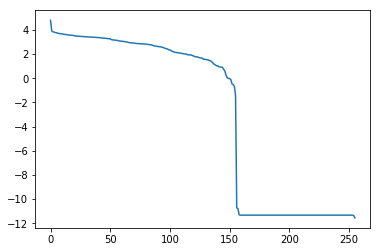

In [14]:
plt.plot(np.log10(s))
plt.show()

Init TensorFlow session

In [9]:
sess = tf.Session()

Init Tensorflow infrastructure. Create the neural network matrices

In [10]:
red_x = tf.placeholder(tf.float32, [None, red_Din], name="red_x")

red_grad1_ph = tf.placeholder(tf.float32, name="red_grad1_ph")
red_grad2_ph = tf.placeholder(tf.float32, name="red_grad2_ph")
red_grad3_ph = tf.placeholder(tf.float32, name="red_grad3_ph")
red_grad4_ph = tf.placeholder(tf.float32, name="red_grad4_ph")


red_W1 = tf.Variable(tf.random_normal([red_Din, D_hid1], stddev=0.0001), name="red_W1")
red_b1 = tf.Variable(tf.random_normal([D_hid1], stddev=0.0001), name="red_b1") 

red_W = tf.Variable(tf.random_normal([D_hid1, Dout], stddev=0.0001), name="red_W")
red_b = tf.Variable(tf.random_normal([Dout], stddev=0.0001), name="red_b")

red_H = tf.nn.relu(tf.matmul(red_x, red_W1) + red_b1)
red_y = tf.nn.softmax(tf.matmul(red_H, red_W) + red_b)
#red_y = tf.nn.softmax(tf.matmul(red_x, red_W) + red_b, name = "red_y")
red_y_ = tf.placeholder(tf.float32, [None, Dout], name="red_y_")

Instructions for updating:
Colocations handled automatically by placer.


loss (error) function

In [11]:
red_square_loss = tf.reduce_mean(tf.pow(red_y_ - red_y, 2))

In [12]:
red_adam = tf.train.AdamOptimizer(learning_rate=lr)

#tvars = tf.trainable_variables()
red_tvars = [red_W, red_b, red_W1, red_b1]

red_grads = red_adam.compute_gradients(loss=red_square_loss, var_list=red_tvars)
red_apply_grads = red_adam.apply_gradients(zip([red_grad1_ph, red_grad2_ph, red_grad3_ph, red_grad4_ph],red_tvars))

In [13]:
sess.run(tf.global_variables_initializer())

In [14]:
rewards = np.ndarray([0], dtype=np.float32)

Learning. It will continue while the file `1.ctl` contains the **RUN** text on the first line.

Iteration: 1 / 1


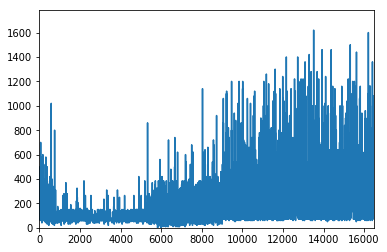

total_num_games=16500 average=192.154 moving_average=331.850 time_mins=4
Iteration: 2 / 1


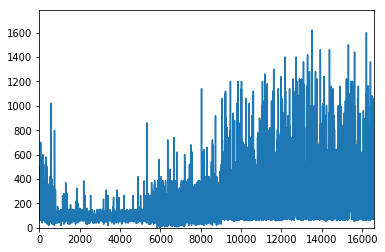

total_num_games=16600 average=192.805 moving_average=300.100 time_mins=5
Iteration: 3 / 1


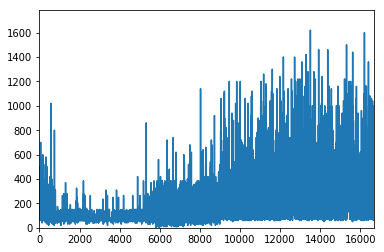

total_num_games=16700 average=193.590 moving_average=323.950 time_mins=5


In [26]:
num_iterations = 1
i = 0
need_stop = False
while(need_stop == False):
#for i in range(num_iterations):
    t1 = time.time()
    print ("Iteration:", i + 1, '/', num_iterations)
    i += 1
    red_games, commulative_rewards = red_play(num_games=num_games, max_steps=3000, render=False, V=V)
    commulative_rewards_np = np.array(commulative_rewards)
    rewards = np.hstack((rewards, commulative_rewards_np))
    x = np.linspace(1, len(rewards), len(rewards))
    plt.plot(x, rewards)
    plt.axis([0, x.size, 0, 1.1 * rewards.max()])
    plt.show()
    red_train_agent2(1, red_games, commulative_rewards_np)
    print("total_num_games=%d average=%.3f moving_average=%.3f time_mins=%d" %
          (x.size, rewards.mean(), rewards[-num_games:].mean(), (time.time() - t1) / 60 ))
    with open("/home/martin/1.ctl") as f:
        cmd = f.readline()
        if cmd.find("RUN") < 0:
            need_stop = True

Playing and render the game on the screen

In [27]:
g, r = red_play(num_games=1, max_steps=5000, render=True, V=V, sleep_s=0.02)

In [ ]:
sess.run(red_W)

In [ ]:
def onehot2int(v):
    for _ in range(len(v)):
        if v[_] == 1:
            return _
    return len(v)

In [ ]:
actions = deque()
onehot2int(red_games[0][0][1])
actions = deque()
for game in games:
    for step in game:
        actions.append(onehot2int(step[1]))

In [ ]:
print (len(actions))

In [ ]:
h = np.histogram(actions, bins=6)
plt.plot(h[1][1:], h[0])
plt.show()
print (h, np.sum(h[0]))

TensorFlow object which can store and load a graph's weights

In [15]:
saver = tf.train.Saver()

Save model routine

In [16]:
def save_model(directory):
    saver.save(sess, directory)
    np.save(directory + "/rewards", rewards)
    np.save(directory + "/V-matrix", V)

In [17]:
# save_model("/home/martin/reinforcement_learning_runs/1/")

Load model routine

In [18]:
def load_model(directory):
    saver.restore(sess=sess, save_path=directory)
    rewards = np.load(directory + "/rewards.npy")
    V = np.load(directory + "/V-matrix.npy")
    return (V, rewards)
    

In [19]:
V, rewards = load_model("/home/martin/reinforcement_learning_runs/5/")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/martin/reinforcement_learning_runs/5/
